In [1]:
import numpy as np
import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg'

from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram

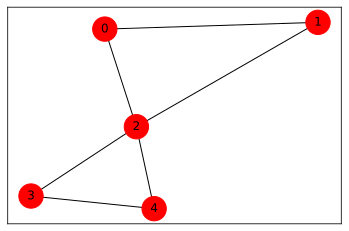

In [23]:
n= 5
V= np.arange(0,n,1)
E= [(0,1,1.0),(0,2,2.0),(1,2,1.0),(3,2,3.0),(3,4,5.0),(4,2,3.0)] # change the value of weights here

G= nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

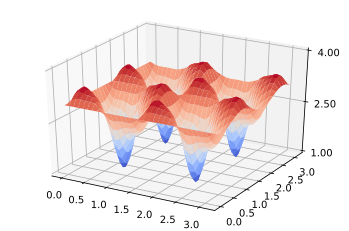

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [24]:
# Function evaluation
step_size= 0.1
a_gamma= np.arange(0, np.pi, step_size)
a_beta= np.arange(0, np.pi, step_size)
a_gamma, a_beta= np.meshgrid(a_gamma,a_beta)

F1= 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plotting the expetation value F1
fig= plt.figure()
ax= fig.gca(projection='3d')
surf= ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

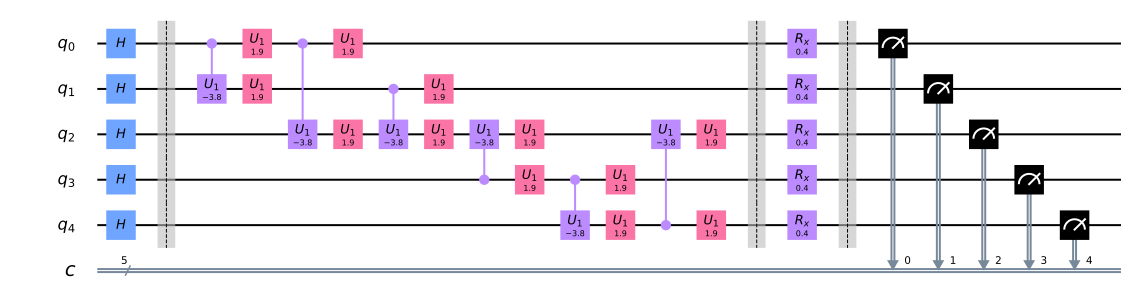

In [25]:
QAOA = QuantumCircuit(len(V), len(V))
QAOA.h(range(len(V)))
QAOA.barrier()

# Applying Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)
    
QAOA.barrier()
# Applying the single qubit rotation gates with angle beta
QAOA.rx(2*beta, range(len(V)))
QAOA.barrier()

QAOA.measure(range(len(V)),range(len(V)))
QAOA.draw(output='mpl')

In [26]:
# Cost function
def cost_function(x,G):
    E= G.edges()
    if( len(x)!= len(G.nodes())):
        return np.nan
    C= 0
    for index in E:
        e1= index[0]
        e2= index[1]
        
        w= G[e1][e2]['weight']
        C= C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])        
    return C

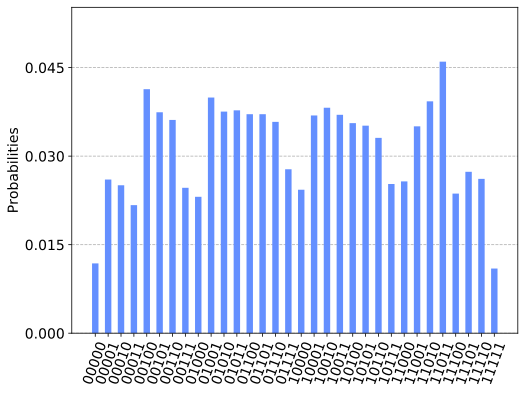

In [27]:
backend= Aer.get_backend("qasm_simulator")
shots= 9216
task= execute(QAOA,backend= backend,shots= shots)
QAOA_results= task.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

The sampled mean value is 8.27 while the true value is 3.43 

The approximate solution is x* = 01101 with C(x*) = 11 

The cost function is distributed as: 



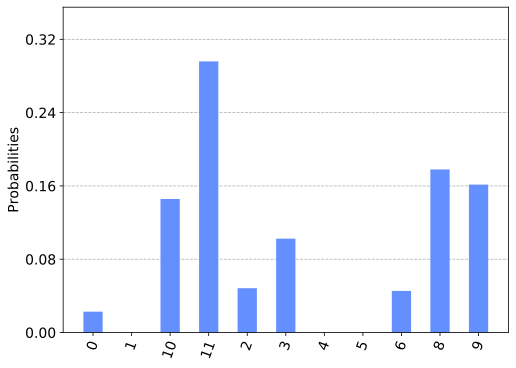

In [28]:
counts= QAOA_results.get_counts()
avr_C= 0
max_C= [0,0]
hist= {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):
    x= [int(num) for num in list(sample)]
    tmp_eng= cost_function(x,G)
    
    avr_C= avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots
print('The sampled mean value is %.02f while the true value is %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)